In [683]:
import numpy as np 
import re
import pandas as pd 
import pandas_profiling
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

# 0. Функции и настройки

In [680]:
RANDOM_SEED = 42
VAL_SIZE   = 0.20 
N_FOLDS    = 5
pd.set_option('display.max_columns', None)

# catboost
ITERATIONS = 5000
LR         = 0.1

In [529]:
# в одном из решений увидел и решил воспользоваться функцией по сравнению train и test - 
# проверить, что столбцы идентичные, мы ничего не пропустили
def check_df_before_merge(d_df1,d_df2):
    """
    Функция, принимает два датасета
    Построчно выдает оба, пишет отчет о несоответствиях
    """
    
    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_dict['# unique_train'] = d_df1.nunique().values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    
    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_dict2['# unique_test'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    temp_insert = pd.DataFrame(columns=['< - >'])
    
    temp_df = pd.concat([temp_df1,temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)
        if temp_df3['# unique_test'][i]>0 and temp_df3['# unique_train'][i]/temp_df3['# unique_test'][i] > 2:
            temp_list5.append(i)
            
    temp_dict3['index']= temp_list4
    temp_dict3['feature_train']= temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['feature_test']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(f'2. Уникальные значения различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)

In [530]:
def df_description(df):
    """
    фнкция, возвращает словарь с описанием датафрейма
    """
    df_dict = {}
    for column in df.columns:
        temp_dict = {}
        temp_dict['type'] = df[column].dtype.kind
        temp_dict['# values'] = df[column].count()
        temp_dict['% na'] = df[column].isna().sum()/df[column].count()
        temp_dict['# unique'] = df[column].nunique()
        temp_dict['example'] = df[column].dropna().unique()[0]
        df_dict[column] = temp_dict
    return df_dict

In [531]:
def box_plot(df, col):
    """
    функция строит график категориальных переменных
    """
    plt.figure(figsize=(10, 5))
    g1 = sns.boxplot(y='log_price', x=col, 
                      data=df, color='coral')
    g1.set_title(col + ' ' +' price', fontsize=20)

    g1.set_ylabel('log_price', fontsize=15)
    g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
    plt.show()

# 1. Данные

### 1.1 Сравним два датасета, найдем несоответствия в столбцах

Загружаем данные (test и собранный train (код по сбору - в отдельном файле). Pandas profiling падает при анализе train, попробуем вручную

In [648]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [533]:
# уберем лишние столбцы и создадим таблицы для изменения
df_train = train[train['hidden'] == False]
df_train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'start_date','hidden', 'car_url','image'], axis=1, inplace=True)
df_train['sample'] = 1

df_test = test
df_test.drop(['car_url','image'], axis=1, inplace=True)
df_test['sample'] = 0

In [534]:
df_train = df_train.drop_duplicates(keep='last').reset_index(drop=True)

In [535]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40611 entries, 0 to 40610
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              40609 non-null  object 
 1   brand                 40611 non-null  object 
 2   color                 28583 non-null  object 
 3   complectation_dict    40609 non-null  object 
 4   description           39131 non-null  object 
 5   engineDisplacement    40609 non-null  object 
 6   enginePower           40609 non-null  float64
 7   equipment_dict        40611 non-null  object 
 8   fuelType              40611 non-null  object 
 9   mileage               40611 non-null  int64  
 10  modelDate             40609 non-null  float64
 11  model_info            40611 non-null  object 
 12  model_name            40611 non-null  object 
 13  name                  40609 non-null  object 
 14  numberOfDoors         40609 non-null  float64
 15  parsing_unixtime   

In [536]:
# сверяем столбцы - видим, где не совпадают типы и различаются уникальные значения
check_df_before_merge(df_train, df_test)

,feature_train,type_train,sample_train,# unique_train,< - >,feature_test,type_test,sample_test,# unique_test
0,bodyType,object,Седан Long,95,| - |,bodyType,object,лифтбек,24.0
1,brand,object,LEXUS,12,| - |,brand,object,SKODA,12.0
2,color,object,чёрный,16,| - |,color,object,серый,16.0
3,complectation_dict,object,"{'id': '22642161', 'body_type': 'SEDAN', 'door...",1790,| - |,complectation_dict,object,"{""id"":""5011515"",""name"":""RS"",""available_options...",2364.0
4,description,object,ID: 44539\n\n- Автомобиль прошел комплексную д...,31956,| - |,description,object,Продаю свой автомобиль! Автомобиль полностью и...,31732.0
5,engineDisplacement,object,600h,378,| - |,engineDisplacement,object,2.0 LTR,55.0
6,enginePower,float64,394,302,| - |,enginePower,object,200 N12,315.0
7,equipment_dict,object,"{'engine-proof': True, 'asr': True, 'esp': Tru...",24559,| - |,equipment_dict,object,"{""cruise-control"":true,""tinted-glass"":true,""es...",23705.0
8,fuelType,object,гибрид,7,| - |,fuelType,object,бензин,5.0
9,mileage,int64,127045,10372,| - |,mileage,int64,172000,11268.0


Резюме:
 1. Не совпали типы в:= 5 столбцах

2. Уникальные значения различаются в:= 2 столбцах [0, 5]


,feature_train,не совпадают типы,feature_test
index,,,
6,enginePower,float64 != object,enginePower
10,modelDate,float64 != int64,modelDate
14,numberOfDoors,float64 != int64,numberOfDoors
15,parsing_unixtime,float64 != int64,parsing_unixtime
30,price,float64 != nan,NaN


### 1.2 Приведем данные train  к такому же виду, как в test

#### 1.2.1 bodyType

In [537]:
df_train['bodyType'].unique()

array(['Внедорожник 5 дв.', 'Седан Long', 'Седан', 'Кабриолет',
       'Универсал 5 дв.', 'Внедорожник 5 дв. L', 'Хэтчбек 5 дв.',
       'Минивэн', 'Купе', 'Хэтчбек 5 дв. Sportback', 'Хэтчбек 3 дв.',
       'Лифтбек Sportback', 'Родстер', 'Кабриолет Roadster', 'Лифтбек',
       'Лифтбек Gran Turismo', 'Седан Gran Coupe', 'Седан 2 дв.',
       'Хэтчбек 3 дв. Compact', 'Лифтбек Gran Coupe', 'Купе-хардтоп',
       'Компактвэн Gran Tourer', 'Компактвэн', 'Седан Type-S', nan,
       'Внедорожник 3 дв.', 'Компактвэн Spike', 'Минивэн Spada',
       'Родстер del Sol', 'Микровэн', 'Минивэн XL', 'Минивэн L',
       'Минивэн Marco Polo', 'Универсал 5 дв. All-Terrain',
       'Лимузин Pullman', 'Хэтчбек 5 дв. Long', 'Минивэн Long',
       'Минивэн Extra Long', 'Минивэн Extralong', 'Минивэн L1',
       'Минивэн L3', 'Минивэн L2', 'Внедорожник 5 дв. 4x4',
       'Внедорожник открытый', 'Седан Pullman', 'Пикап Двойная кабина',
       'Купе Asti', 'Пикап Полуторная кабина', 'Седан Latio',
       'Комп

In [538]:
df_test['bodyType'].unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [539]:
df_test['body_type'] = [str(x).lower().replace('.', '') for x in df_test['bodyType']]
df_train['body_type'] = [str(x).lower() for x in df_train['bodyType']]

In [540]:
# Заменим длинные типы в train'е на обобщенные значения
body_type_list = list(df_test['body_type'].unique())
def get_perf_type(x, body_type_list):
    for t in body_type_list:
        if t in x:
            return t
        else: continue
    else: return '0'

In [541]:
df_train['body_type'] = df_train['body_type'].apply(lambda x: get_perf_type(x, body_type_list))

In [542]:
# смотрим записи, где не нашлось соответствия. 
# Видим, что в столбце fuelType записан что-то похожее на body_type
# При этом в остальных столбцах куча NaN - удалим этим записи
df_train[df_train['body_type']=='0']

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,sample,body_type
9625,NaN,HONDA,серебристый,NaN,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,{},универсал,400000,NaN,"{'code': 'CIVIC', 'name': 'Civic', 'ru_name': ...",CIVIC,NaN,NaN,1.611241e+09,RUR,1989,1097454742,NaN,NaN,NaN,JAPANESE,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,120000.0,1,0
37998,NaN,VOLKSWAGEN,синий,NaN,На ходу. Двигатель капитальный.,NaN,NaN,{},минивэн,150000,NaN,"{'code': 'TRANSPORTER', 'name': 'Transporter',...",TRANSPORTER,NaN,NaN,1.611277e+09,RUR,1994,1096187814,NaN,NaN,NaN,EUROPEAN,3 или более,NaN,Оригинал,NaN,Левый,Не требует ремонта,Растаможен,300000.0,1,0


In [543]:
df_train.drop(columns=['bodyType'], inplace=True)
df_test.drop(columns=['bodyType'], inplace=True)

#### 1.2.2 brand

In [544]:
print(sorted(df_train['brand'].unique()))

['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES', 'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']


In [545]:
print(sorted(df_test['brand'].unique()))

['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES', 'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']


Одинаковое количество брендов и одинаковое написание

#### 1.2.3 color

In [546]:
df_train['color'].unique()

array([nan, 'белый', 'чёрный', 'серебристый', 'бежевый', 'серый',
       'коричневый', 'синий', 'красный', 'пурпурный', 'золотистый',
       'зелёный', 'фиолетовый', 'голубой', 'жёлтый', 'оранжевый',
       'розовый'], dtype=object)

In [547]:
print(sorted(df_test['color'].unique()))

['бежевый', 'белый', 'голубой', 'жёлтый', 'зелёный', 'золотистый', 'коричневый', 'красный', 'оранжевый', 'пурпурный', 'розовый', 'серебристый', 'серый', 'синий', 'фиолетовый', 'чёрный']


In [548]:
df_train[df_train['color'].isna()]

,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,sample,body_type
0,LEXUS,NaN,"{'id': '21394700', 'body_type': 'ALLROAD_5_DOO...",Комплектация #enjoy\n\n\nПредложение обновлено...,200,150.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,0,2018.0,"{'code': 'UX', 'name': 'UX', 'ru_name': 'UX', ...",UX,200 2.0 CVT (150 л.с.),5.0,1.611233e+09,RUR,2020,1102138658,"{'id': '21394651', 'name': 'I', 'ru_name': '1'...",ALLROAD_5_DOORS VARIATOR 200,NaN,JAPANESE,NaN,NaN,NaN,передний,NaN,0,NaN,2746000.0,1,внедорожник 5 дв
111,LEXUS,NaN,"{'id': '21328607', 'body_type': 'SEDAN', 'door...",СПЕЦИАЛЬНЫЕ ЦЕНЫ ТОЛЬКО 21 января!\nЗвоните се...,250,200.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,0,2018.0,"{'code': 'ES', 'name': 'ES', 'ru_name': 'ES', ...",ES,250 2.5 AT (200 л.с.),4.0,1.611233e+09,RUR,2021,1102208282,"{'id': '21328546', 'name': 'VII', 'ru_name': '...",SEDAN AUTOMATIC 250,NaN,JAPANESE,NaN,NaN,NaN,передний,NaN,0,NaN,3355500.0,1,седан
115,LEXUS,NaN,"{'id': '21328607', 'body_type': 'SEDAN', 'door...",СПЕЦИАЛЬНЫЕ ЦЕНЫ ТОЛЬКО 21 января!\nЗвоните се...,250,200.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,0,2018.0,"{'code': 'ES', 'name': 'ES', 'ru_name': 'ES', ...",ES,250 2.5 AT (200 л.с.),4.0,1.611233e+09,RUR,2020,1102208285,"{'id': '21328546', 'name': 'VII', 'ru_name': '...",SEDAN AUTOMATIC 250,NaN,JAPANESE,NaN,NaN,NaN,передний,NaN,0,NaN,3333000.0,1,седан
119,LEXUS,NaN,"{'id': '21328607', 'body_type': 'SEDAN', 'door...",СПЕЦИАЛЬНЫЕ ЦЕНЫ ТОЛЬКО 21 января!\nЗвоните се...,250,200.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,0,2018.0,"{'code': 'ES', 'name': 'ES', 'ru_name': 'ES', ...",ES,250 2.5 AT (200 л.с.),4.0,1.611233e+09,RUR,2021,1102208281,"{'id': '21328546', 'name': 'VII', 'ru_name': '...",SEDAN AUTOMATIC 250,NaN,JAPANESE,NaN,NaN,NaN,передний,NaN,0,NaN,3333000.0,1,седан
125,LEXUS,NaN,"{'id': '21328607', 'body_type': 'SEDAN', 'door...",СПЕЦИАЛЬНЫЕ ЦЕНЫ ТОЛЬКО 21 января!\nЗвоните се...,250,200.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,0,2018.0,"{'code': 'ES', 'name': 'ES', 'ru_name': 'ES', ...",ES,250 2.5 AT (200 л.с.),4.0,1.611233e+09,RUR,2021,1102183429,"{'id': '21328546', 'name': 'VII', 'ru_name': '...",SEDAN AUTOMATIC 250,NaN,JAPANESE,NaN,NaN,NaN,передний,NaN,0,NaN,3248000.0,1,седан
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40025,VOLVO,NaN,"{'id': '21320121', 'body_type': 'SEDAN', 'door...",Официальный дилер Volvo Car Тульская. \nПредла...,2.0,190.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,0,2018.0,"{'code': 'S60', 'name': 'S60', 'ru_name': 'S60...",S60,2.0 AT (190 л.с.),4.0,1.611278e+09,RUR,2020,1102078619,"{'id': '21320062', 'name': 'III', 'ru_name': '...",SEDAN AUTOMATIC 2.0,NaN,EUROPEAN,NaN,NaN,NaN,передний,NaN,0,NaN,3362700.0,1,седан
40346,VOLVO,NaN,"{'id': '22197359', 'body_type': 'SEDAN', 'door...",ЛОТ: 01225791\n\nСкидка на автомобиль\n- при п...,2.0,190.0,"{'asr': True, 'roller-blind-for-rear-window': ...",бензин,0,2020.0,"{'code': 'S90', 'name': 'S90', 'ru_name': 'S90...",S90,2.0 AT (190 л.с.),4.0,1.611278e+09,RUR,2020,1101367907,"{'id': '22196923', 'name': 'II Рестайлинг', 'r...",SEDAN AUTOMATIC 2.0,NaN,EUROPEAN,NaN,NaN,NaN,передний,NaN,0,NaN,3784740.0,1,седан
40350,VOLVO,NaN,"{'id': '22197359', 'body_type': 'SEDAN', 'door...",ЛОТ: 01225783\n\nСкидка на автомобиль\n- при п...,2.0,190.0,"{'asr': True, 'roller-blind-for-rear-window': ...",бензин,0,2020.0,"{'code': 'S90', 'name': 'S90', 'ru_name': 'S90...",S90,2.0 AT (190 л.с.),4.0,1.611278e+09,RUR,2020,1101367906,"{'id': '22196923', 'name': 'II Рестайлинг', 'r...",SEDAN AUTOMATIC 2.0,NaN,EUROPEAN,NaN,NaN,NaN,передни

In [549]:
# 32 записи, где нет цвета. в будущем можно поковыряться с ними, а пока удалим
df_train.dropna(subset=['color'], inplace=True)

#### 1.2.4 complectation_dict и description

Словарь и текст - пока отложим эти столбцы, в первом заходе не будем их использовать.

#### 1.2.5 engineDisplacement

In [550]:
df_train['engineDisplacement'].value_counts().head(30)

2.0     3520
1.6     3199
1.8     2014
1.4     1456
2.5     1060
200      938
350      915
2.4      845
2.0d     643
3.5      640
3.0d     608
3.0      492
250      458
500      413
2.5d     382
180      361
1.2      358
30d      326
300      289
1.5      284
2.4d     282
4.5d     255
63       245
320i     240
1.3      225
400      209
35i      197
220      196
320      192
20d      176
Name: engineDisplacement, dtype: int64

Видим, что спарсились странные данные. Попробуем вытащить литраж из поля name - там это цифра с точкой посередине

In [551]:
pattern = re.compile('(\d{1}\.\d{1})')
df_train['engineDisplacement'] = df_train['name'].apply(lambda x:str(pattern.findall(str(x)))[2:5])
df_train['engineDisplacement'] = pd.to_numeric(df_train['engineDisplacement'], errors='coerce')

In [552]:
df_train['engineDisplacement'].value_counts()

2.0    6641
1.6    3858
3.0    3492
1.8    2511
2.5    1919
1.4    1509
3.5    1372
2.4    1206
1.5     464
1.2     370
4.4     326
1.3     325
4.5     322
4.7     314
4.0     312
5.5     309
2.1     305
2.8     302
3.2     291
2.2     217
2.3     178
4.2     170
3.7     159
3.6     158
1.9     152
5.0     148
2.7     146
5.6     123
2.9     116
5.7     108
4.6      93
4.8      73
2.6      55
3.1      54
1.7      54
3.8      52
6.0      44
6.2      38
0.7      37
3.3      36
1.0      35
5.4      25
4.1      24
3.4      21
4.3      19
5.8       8
4.9       8
5.2       6
6.6       5
6.3       5
5.9       4
1.1       1
5.3       1
3.9       1
Name: engineDisplacement, dtype: int64

In [553]:
df_test['engineDisplacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

In [554]:
df_test['engineDisplacement'] = df_test['engineDisplacement'].apply(lambda x: str(x).replace('LTR', ''))
df_test['engineDisplacement'] = pd.to_numeric(df_test['engineDisplacement'], errors='coerce')

In [555]:
df_test['engineDisplacement'].value_counts()

2.0    7391
1.6    4973
3.0    3915
1.8    3349
2.5    2477
2.4    1745
3.5    1710
1.4    1635
1.5     725
1.2     485
4.4     447
2.8     384
4.7     377
1.3     365
5.5     361
4.0     356
3.2     348
4.5     346
2.1     271
3.7     242
2.2     236
4.2     228
1.9     221
2.3     203
2.7     189
3.6     183
5.6     170
5.0     158
5.7     135
2.9     131
4.6     108
3.1      88
4.8      84
1.7      59
1.0      57
3.8      57
2.6      55
6.0      53
0.7      53
3.3      44
3.4      36
4.1      35
4.3      32
5.4      31
6.2      28
5.2      12
5.9      12
6.3       8
5.8       7
6.6       6
1.1       4
4.9       4
3.9       1
5.3       1
Name: engineDisplacement, dtype: int64

In [556]:
# видим машины с электродвигателями, у которых нет объема двигателя. подумаем, что с ними делать, позже.
df_test[df_test['engineDisplacement'] == ' LTR'].head()

,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sample,body_type


#### 1.2.6 enginePower

In [557]:
pattern = re.compile('^(\d+)\.*')
df_test['enginePower'] = df_test['enginePower'].apply(lambda x: int(str(pattern.findall(x))[2:-2]))
df_train.dropna(subset=['enginePower'], inplace=True)
df_train['enginePower'] = df_train['enginePower'].astype('int64')

#### 1.2.7 equipmentDict

В обоих датасетах идентичные столбцы, с данными пока ничего не делаем

#### 1.2.8 fuelType

In [558]:
df_train['fuelType'].unique()

array(['бензин', 'гибрид', 'дизель', 'электро', 'газ'], dtype=object)

In [559]:
df_test['fuelType'].unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

#### 1.2.9 mileage

Данные идентичны, ничего не надо делать

#### 1.2.10 modelDate

In [560]:
df_train['modelDate'] = df_train['modelDate'].fillna(0).astype('int64')

#### 1.2.11 model_name

Изменений не нужно

#### 1.2.12 name

Данные в колонках идентичны, пока отложим их

#### 1.2.13 numberOfDoors

In [561]:
# Заполним пропуски значением 0 и поправим формат в тренировочных данных
df_train['numberOfDoors'] = df_train['numberOfDoors'].fillna(0).astype('int64')

#### 1.2.14 priceCurrency

In [562]:
df_train['priceCurrency'] = df_train['priceCurrency'].map({'RUR':'RUB'})

#### 1.2.15 productionDate

Не требует изменений

#### 1.2.16 super_gen и vehicleConfiguration

Данные в колонках идентичны, пока отложим их

#### 1.2.17 vehicleTransmission, vendor и владельцы

Не требует изменений

#### 1.12.18 Владение

In [563]:
df_train['Владение'].value_counts()

1 год и 1 месяц        171
2 года и 1 месяц       157
2 года и 2 месяца      148
1 год и 10 месяцев     144
1 год и 2 месяца       138
                      ... 
17 лет и 12 месяцев      1
20 лет и 5 месяцев       1
21 год и 10 месяцев      1
21 год                   1
19 лет и 2 месяца        1
Name: Владение, Length: 260, dtype: int64

In [564]:
df_test['Владение'].value_counts()

1 год и 10 месяцев      209
2 года                  197
1 год                   194
1 год и 1 месяц         193
1 год и 2 месяца        187
                       ... 
29 лет и 9 месяцев        1
26 лет и 7 месяцев        1
42 года и 10 месяцев      1
22 года и 3 месяца        1
19 лет и 9 месяцев        1
Name: Владение, Length: 275, dtype: int64

In [565]:
def count_ownership(string):
    """
    функция считает кол-во месяцев владения из поля 'Владение'
    Возвращает месяцы владения или 0 - в случае NaN
    """
    try:
        num = [int(s) for s in string.split() if s.isdigit()] # вытаскиваем все цифры
        if len(num) == 2: # если у нас год и месяц
            return num[0]*12 + num[1]
        if len(num) == 1: # если у нас одна цифра - год, лет или месяц
            if 'месяц' in string:
                return num[0]
            else: # если "год" или "лет"
                return num[0]*12
    # если у нас NaN - вернем 0        
    except: 
        return 0

In [566]:
df_test['ownership_months'] = df_test['Владение'].apply(lambda x: count_ownership(x))
df_train['ownership_months'] = df_train['Владение'].apply(lambda x: count_ownership(x))

In [567]:
# проверим работу функции
df_test.dropna(subset=['Владение'])[['Владение','ownership_months']].sample(20)

,Владение,ownership_months
14709,8 месяцев,8
6152,3 года и 10 месяцев,46
19228,1 месяц,1
18652,8 лет и 9 месяцев,105
23868,11 месяцев,11
24688,4 года и 9 месяцев,57
8302,4 года,48
4103,2 года и 1 месяц,25
17622,4 года и 2 месяца,50
29671,7 лет и 7 месяцев,91


#### 1.12.19 ПТС, привод, руль, состояние, таможня

Идентичны, изменения не нужны

#### 1.12.20 parsing_unixtime

In [568]:
df_train['parsing_unixtime'] = df_train['parsing_unixtime'].astype('int64')

#### 1.12.20 Проверим еще раз

In [569]:
check_df_before_merge(df_train, df_test)

,feature_train,type_train,sample_train,# unique_train,< - >,feature_test,type_test,sample_test,# unique_test
0,brand,object,LEXUS,12,| - |,brand,object,SKODA,12.0
1,color,object,чёрный,16,| - |,color,object,серый,16.0
2,complectation_dict,object,"{'id': '22642161', 'body_type': 'SEDAN', 'door...",1763,| - |,complectation_dict,object,"{""id"":""5011515"",""name"":""RS"",""available_options...",2364.0
3,description,object,ID: 44539\n\n- Автомобиль прошел комплексную д...,24124,| - |,description,object,Продаю свой автомобиль! Автомобиль полностью и...,31732.0
4,engineDisplacement,float64,5,54,| - |,engineDisplacement,float64,2,54.0
5,enginePower,int64,394,300,| - |,enginePower,int64,200,315.0
6,equipment_dict,object,"{'engine-proof': True, 'asr': True, 'esp': Tru...",21299,| - |,equipment_dict,object,"{""cruise-control"":true,""tinted-glass"":true,""es...",23705.0
7,fuelType,object,гибрид,5,| - |,fuelType,object,бензин,5.0
8,mileage,int64,127045,10371,| - |,mileage,int64,172000,11268.0
9,modelDate,int64,2006,64,| - |,modelDate,int64,2008,66.0


Резюме:
 1. Не совпали типы в:= 1 столбцах

2. Уникальные значения различаются в:= 0 столбцах []


,feature_train,не совпадают типы,feature_test
index,,,
29,price,float64 != nan,NaN


Видим, что данные в обоих датасетах идентичны, за исключением столбца price, который есть только в df_train

In [570]:
len(df_train[df_train['price'].isna()])

111

In [571]:
# удалим записи из train, где нет цены
df_train.dropna(subset=['price'], inplace=True)

In [572]:
# Объединим оба датасета в один
df = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [573]:
pd.DataFrame.from_dict(df_description(df), orient='index')

,type,# values,% na,# unique,example
brand,O,63156,0.000000,12,SKODA
color,O,63156,0.000000,16,синий
complectation_dict,O,34888,0.810250,4127,"{""id"":""20026336"",""name"":""Ambition"",""available_..."
description,O,61712,0.023399,51921,"Все автомобили, представленные в продаже, прох..."
engineDisplacement,f,63042,0.001808,54,1.2
enginePower,i,63156,0.000000,321,105
equipment_dict,O,53160,0.188036,44924,"{""engine-proof"":true,""tinted-glass"":true,""airb..."
fuelType,O,63156,0.000000,5,бензин
mileage,i,63156,0.000000,19034,74000
modelDate,i,63156,0.000000,66,2013


## 2. EDA

#### 2.1 Подготовка

In [574]:
# опыт подсказывает, что у владельцев и шоурумов могут быть разные ценовые политики, 
# попробуем достать эти данные из поля description
df['description'] = df['description'].map(lambda x: str(x).lower())

df['owner'] = df['description'].apply(lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x)<250 else 0)
df['showroom'] = df['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                             or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x 
                                             or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(df['owner'].value_counts())
display(df['showroom'].value_counts())

1    32664
0    30492
Name: owner, dtype: int64

0    40671
1    22485
Name: showroom, dtype: int64

In [575]:
seller_list = df['sell_id'].value_counts().loc[lambda x: x>1].reset_index()['index'].tolist()
df['if_many_ads'] = df['sell_id'].isin(seller_list)
display(df['if_many_ads'].value_counts())

False    50747
True     12409
Name: if_many_ads, dtype: int64

In [576]:
# удалим ненужные столбцы - возможно, вернемся к ним позже
drop_cols = ['complectation_dict', 'description', 'equipment_dict', 'model_info', 'name',
             'parsing_unixtime', 'priceCurrency', 'sell_id', 'super_gen', 'vehicleConfiguration', 
            'Владение', 'Таможня', 'Состояние']
df.drop(columns=drop_cols, inplace=True)

# тк разброс цены большой, для удобства добавим логарифм цены
df['log_price'] = np.log(df['price'])

In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63156 entries, 0 to 63155
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                63156 non-null  object 
 1   color                63156 non-null  object 
 2   engineDisplacement   63042 non-null  float64
 3   enginePower          63156 non-null  int64  
 4   fuelType             63156 non-null  object 
 5   mileage              63156 non-null  int64  
 6   modelDate            63156 non-null  int64  
 7   model_name           63156 non-null  object 
 8   numberOfDoors        63156 non-null  int64  
 9   productionDate       63156 non-null  int64  
 10  vehicleTransmission  63156 non-null  object 
 11  vendor               63156 non-null  object 
 12  Владельцы            63151 non-null  object 
 13  ПТС                  63154 non-null  object 
 14  Привод               63156 non-null  object 
 15  Руль                 63156 non-null 

Теперь попробуем изучить в pandas_profiling

In [578]:
pandas_profiling.ProfileReport(df, minimal=True)

#### 2.2 Категориальные признаки

In [579]:
cat_cols = ['brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission',
           'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'body_type',
           'owner', 'showroom','if_many_ads']

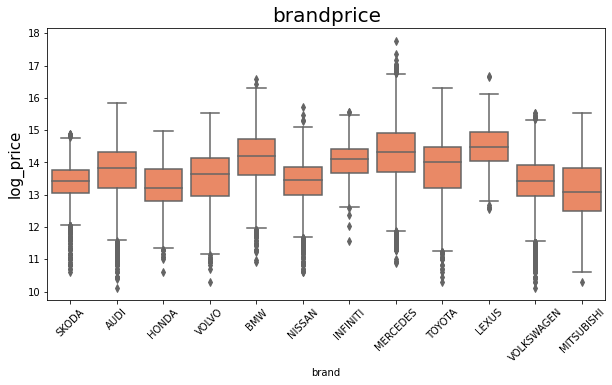

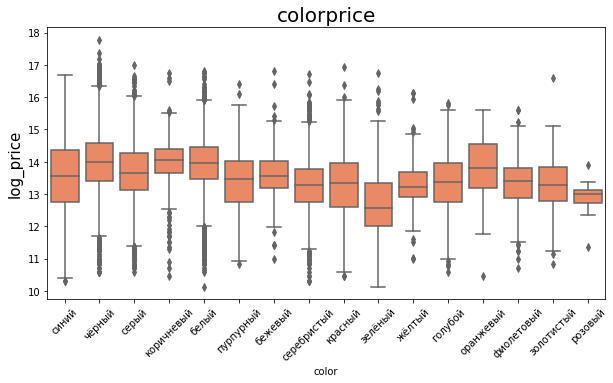

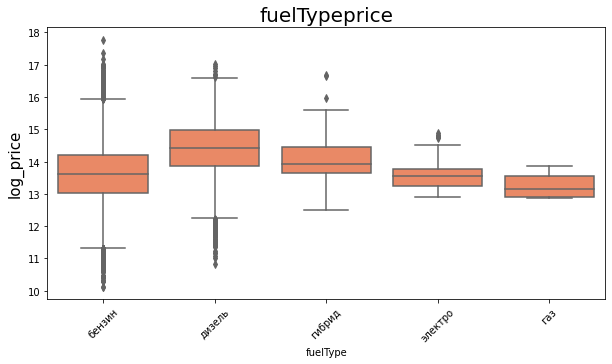

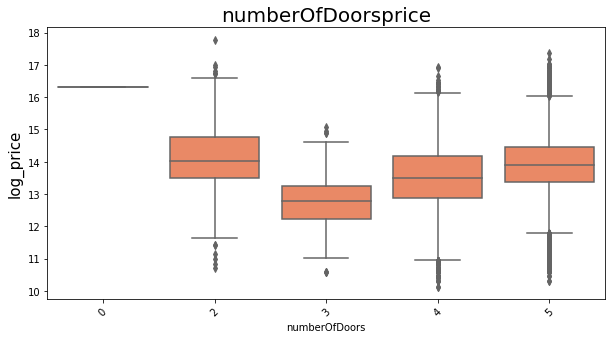

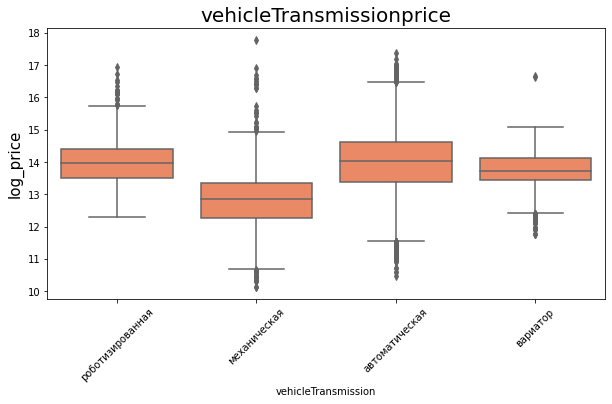

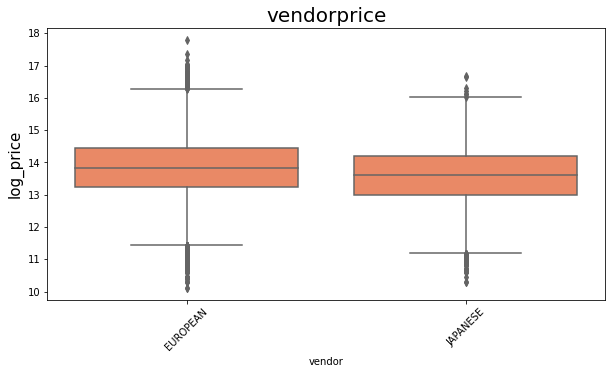

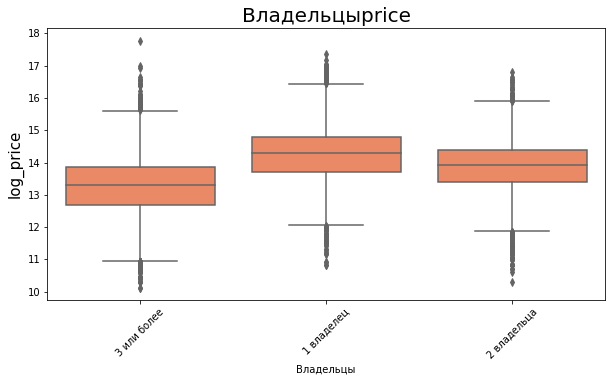

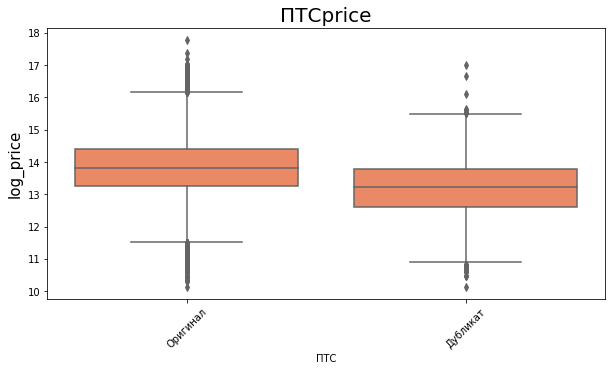

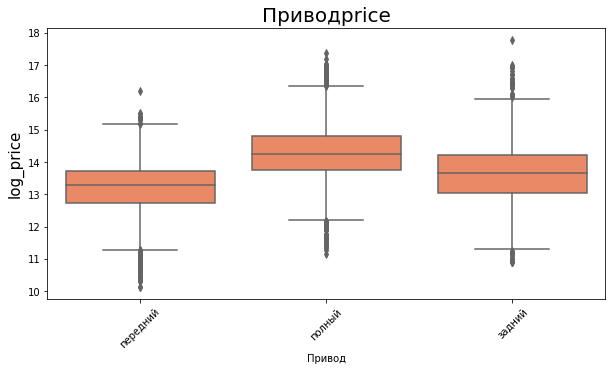

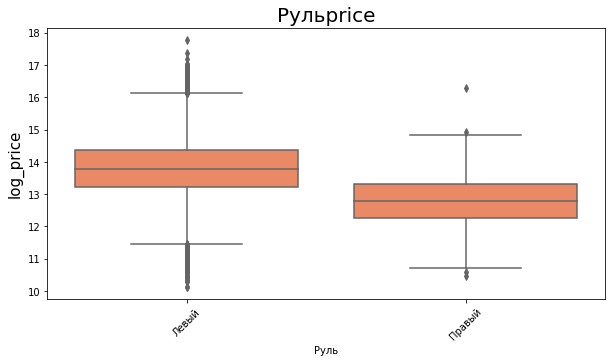

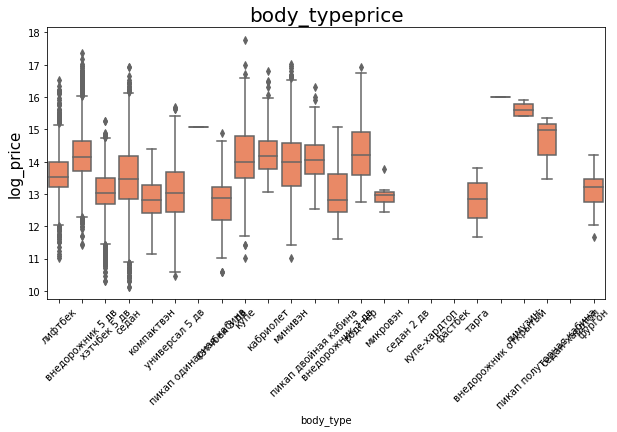

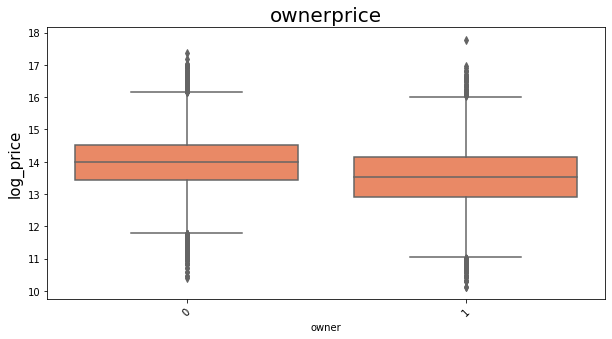

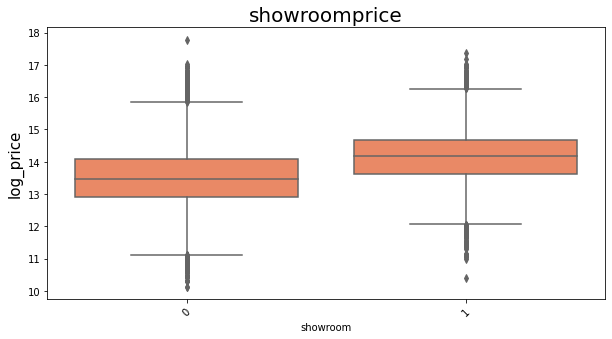

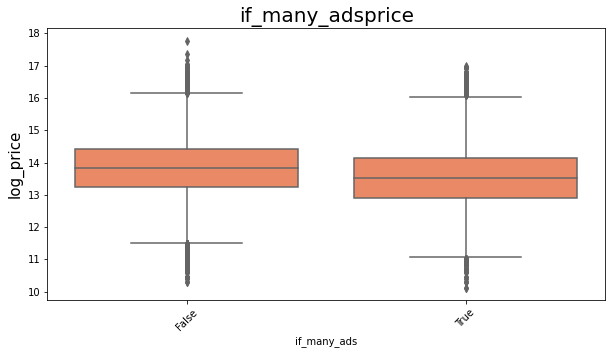

In [580]:
for col in cat_cols:
    box_plots(df, col)

In [581]:
# уберем пропуски
df['ПТС'].fillna('Оригинал', inplace=True)
df['Владельцы'].fillna('1 владелец', inplace=True) # анализ показал, что скорее там 1 владелец или 0
cat_cols.append('model_name')

#### 2.3 Количественные признаки

#### 2.3.1 engineDisplacement

In [582]:
# уберем пропуски
df['eng_koef'] = df['engineDisplacement']/df['enginePower']
df['eng_koef'].mean()

0.013382363949266016

In [583]:
df['engineDisplacement'].fillna(df['enginePower']*0.0134, inplace=True)
df.drop(columns=['eng_koef'], inplace=True)

<AxesSubplot:>

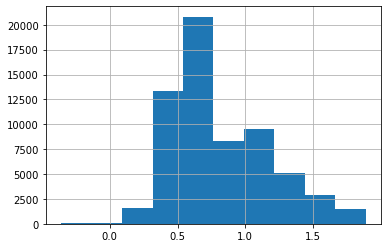

In [584]:
df['log_engineDisplacement'] = np.log(df['engineDisplacement'])
df['log_engineDisplacement'].hist()

#### 2.3.2 enginePower

<AxesSubplot:>

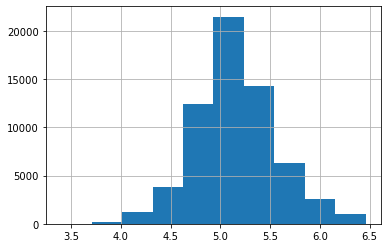

In [585]:
df['log_enginePower'] = np.log(df['enginePower'])
df['log_enginePower'].hist()

Видно, что плогарифмирование enginePower делает распределение более нормальным

#### 2.3.3 mileage

<AxesSubplot:>

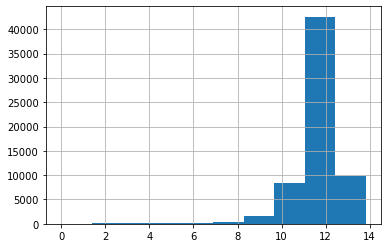

In [586]:
df['log_mileage'] = np.log(df['mileage'])
df['log_mileage'].hist()

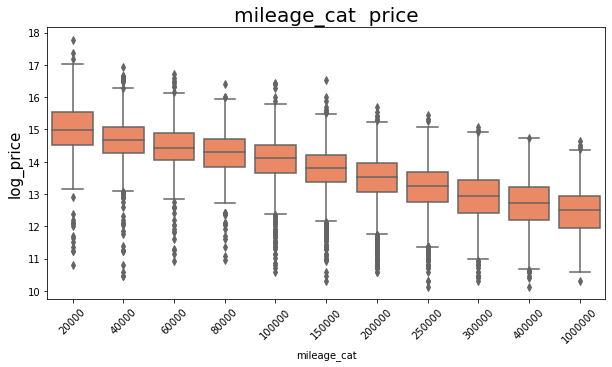

In [587]:
# логарифмирование нам ничего не дает, попробуем на основе этой переменной сделать категориальную
bins = [-1, 20000, 40000, 60000, 80000, 100000, 150000, 200000, 250000, 300000, 400000, 1000001]
numbers = ['20000', '40000','60000','80000','100000', '150000', '200000','250000','300000','400000','1000000']
df['mileage_cat']=pd.cut(df['mileage'],bins,labels=numbers)
box_plot(df,'mileage_cat')

In [588]:
# возможно, новый признак нам пригодится
cat_cols.append('mileage_cat')

#### 2.3.4 modelDate

<AxesSubplot:>

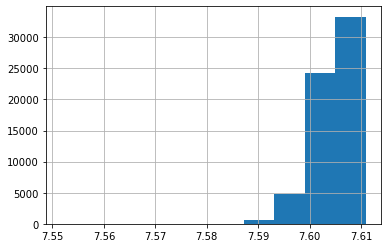

In [589]:
df['log_modelDate'] = np.log(df['modelDate'])
df['log_modelDate'].hist()

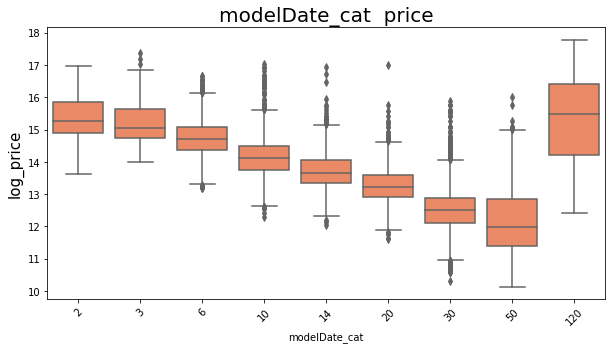

In [590]:
bins = [-1, 2, 3, 6, 10, 14, 20, 30, 50, 120]
numbers = ['2','3','6','10','14','20','30','50','120']

df['modelDate_cat']=pd.cut(2021 - df['modelDate'],bins,labels=numbers)
box_plot(df,'modelDate_cat')

In [591]:
# возможно, новый признак нам пригодится
cat_cols.append('modelDate_cat')

#### 2.3.5 productionDate

<AxesSubplot:>

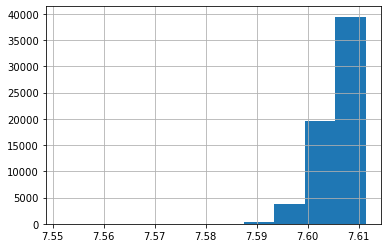

In [592]:
df['log_productionDate'] = np.log(df['productionDate'])
df['log_productionDate'].hist()

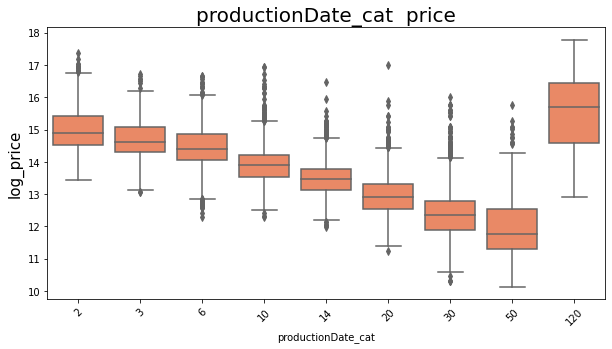

In [593]:
bins = [-1, 2, 3, 6, 10, 14, 20, 30, 50, 120]
numbers = ['2','3','6','10','14','20','30','50','120']

df['productionDate_cat']=pd.cut(2021 - df['productionDate'],bins,labels=numbers)
box_plot(df,'productionDate_cat')

In [594]:
cat_cols.append('productionDate_cat')

#### 2.3.6 ownership_months

<AxesSubplot:>

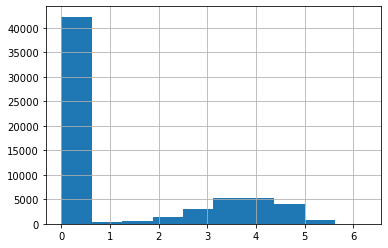

In [595]:
df['log_ownership_months'] = np.log(df['ownership_months']+1)
df['log_ownership_months'].hist()

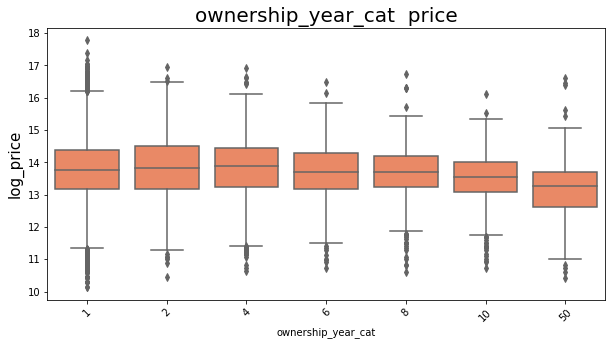

In [596]:
bins = [-1, 1, 2, 4, 6, 8, 10,50]
numbers = ['1','2','4','6','8','10','50']

df['ownership_year_cat']=pd.cut(df['ownership_months']/12,bins,labels=numbers)
box_plot(df,'ownership_year_cat')

Видим, что срок владения как-то значительно не влияет на цену

In [605]:
df.drop(columns=['ownership_year_cat'], inplace=True)

In [606]:
num_cols = ['engineDisplacement','enginePower','mileage','modelDate','productionDate',
            'ownership_months','log_enginePower','log_price']

In [639]:
cat_cols

['brand',
 'color',
 'fuelType',
 'numberOfDoors',
 'vehicleTransmission',
 'vendor',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль',
 'body_type',
 'owner',
 'showroom',
 'model_name',
 'mileage_cat',
 'modelDate_cat',
 'productionDate_cat']

In [607]:
# проверим еще раз датасет - нет ли пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63156 entries, 0 to 63155
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   brand                   63156 non-null  object  
 1   color                   63156 non-null  object  
 2   engineDisplacement      63156 non-null  float64 
 3   enginePower             63156 non-null  int64   
 4   fuelType                63156 non-null  object  
 5   mileage                 63156 non-null  int64   
 6   modelDate               63156 non-null  int64   
 7   model_name              63156 non-null  object  
 8   numberOfDoors           63156 non-null  int64   
 9   productionDate          63156 non-null  int64   
 10  vehicleTransmission     63156 non-null  object  
 11  vendor                  63156 non-null  object  
 12  Владельцы               63156 non-null  object  
 13  ПТС                     63156 non-null  object  
 14  Привод                

In [599]:
correlation = df[num_cols].corr()
correlation

,engineDisplacement,enginePower,mileage,modelDate,productionDate,ownership_months,log_enginePower,log_price
engineDisplacement,1.000000,0.838392,0.008655,0.015143,-0.007368,0.046809,0.816526,0.391207
enginePower,0.838392,1.000000,-0.197330,0.249154,0.220749,-0.011056,0.955250,0.569151
mileage,0.008655,-0.197330,1.000000,-0.656602,-0.675568,0.113410,-0.202241,-0.645801
modelDate,0.015143,0.249154,-0.656602,1.000000,0.975393,-0.152043,0.297252,0.721110
productionDate,-0.007368,0.220749,-0.675568,0.975393,1.000000,-0.154349,0.263571,0.726983
ownership_months,0.046809,-0.011056,0.113410,-0.152043,-0.154349,1.000000,-0.009360,-0.082350
log_enginePower,0.816526,0.955250,-0.202241,0.297252,0.263571,-0.009360,1.000000,0.621903
log_price,0.391207,0.569151,-0.645801,0.721110,0.726983,-0.082350,0.621903,1.000000


<AxesSubplot:>

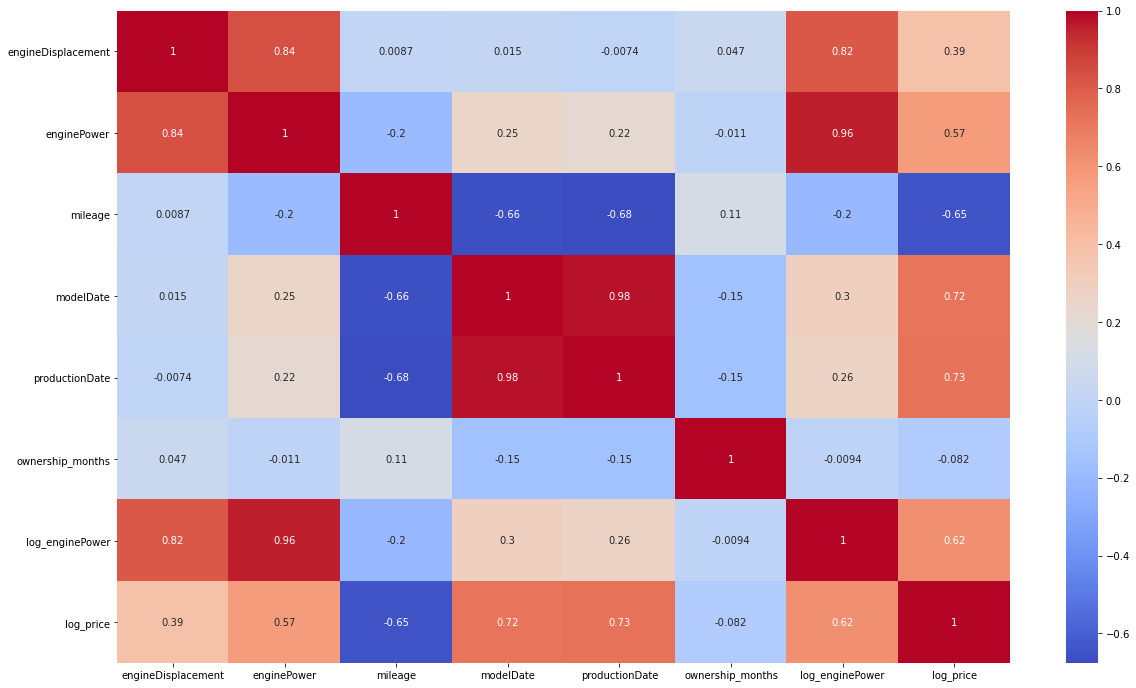

In [600]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

## 3. Строим модель

#### 3.1 Catboost

Попробуем просто "скормить" все данные

In [626]:
X = df[df['sample'] == 1].drop(['sample','price','log_price'], axis=1)
X_sub = df[df['sample'] == 0].drop(['sample','price','log_price'], axis=1)

In [610]:
y = df['log_price'][df['sample'] == 1]

In [614]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [617]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=cat_cols,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0500696	test: 0.0513116	best: 0.0513116 (0)	total: 203ms	remaining: 3m 23s
100:	learn: 0.0116796	test: 0.0118289	best: 0.0118289 (100)	total: 4.92s	remaining: 43.8s
200:	learn: 0.0104203	test: 0.0107866	best: 0.0107866 (200)	total: 9.16s	remaining: 36.4s
300:	learn: 0.0098232	test: 0.0103939	best: 0.0103939 (300)	total: 13.6s	remaining: 31.7s
400:	learn: 0.0093870	test: 0.0101497	best: 0.0101496 (399)	total: 18s	remaining: 26.9s
500:	learn: 0.0090313	test: 0.0099322	best: 0.0099322 (500)	total: 22.4s	remaining: 22.3s
600:	learn: 0.0087715	test: 0.0098460	best: 0.0098460 (600)	total: 27.4s	remaining: 18.2s
700:	learn: 0.0085340	test: 0.0097490	best: 0.0097490 (700)	total: 32.2s	remaining: 13.7s
800:	learn: 0.0083199	test: 0.0096717	best: 0.0096717 (800)	total: 36.9s	remaining: 9.17s
900:	learn: 0.0081357	test: 0.0096035	best: 0.0096035 (900)	total: 41.6s	remaining: 4.58s
999:	learn: 0.0079705	test: 0.0095491	best: 0.0095483 (997)	total: 46.3s	remaining: 0us

bestTest = 0.009

In [632]:
predict = model.predict(X_test)

In [630]:
predict_submission = np.exp(model.predict(X_sub))
len(predict_submission)

34686

In [631]:

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_1.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.409868e+05
1,1100549428,9.611199e+05
2,1100658222,9.217340e+05
3,1100937408,7.937279e+05
4,1101037972,7.253791e+05
5,1100912634,7.738142e+05
6,1101228730,7.109029e+05
7,1100165896,4.384688e+05
8,1100768262,2.130984e+06
9,1101218501,8.675104e+05


In [661]:
X = df[df['sample'] == 1].drop([
    'sample','price','log_price', 'engineDisplacement','ownership_months','enginePower','if_many_ads'], axis=1)
X_sub = df[df['sample'] == 0].drop([
    'sample','price','log_price', 'engineDisplacement','ownership_months','enginePower','if_many_ads'], axis=1)

In [662]:
y = df['log_price'][df['sample'] == 1]

In [663]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [672]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=cat_cols,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0501314	test: 0.0513579	best: 0.0513579 (0)	total: 56.1ms	remaining: 4m 40s
100:	learn: 0.0115389	test: 0.0117728	best: 0.0117728 (100)	total: 5.06s	remaining: 4m 5s
200:	learn: 0.0103473	test: 0.0107880	best: 0.0107880 (200)	total: 9.88s	remaining: 3m 55s
300:	learn: 0.0097723	test: 0.0103918	best: 0.0103918 (300)	total: 14.9s	remaining: 3m 52s
400:	learn: 0.0094259	test: 0.0101980	best: 0.0101975 (398)	total: 20.3s	remaining: 3m 52s
500:	learn: 0.0090944	test: 0.0100047	best: 0.0100047 (500)	total: 25.2s	remaining: 3m 46s
600:	learn: 0.0088672	test: 0.0099002	best: 0.0099002 (600)	total: 30.3s	remaining: 3m 41s
700:	learn: 0.0086628	test: 0.0098402	best: 0.0098402 (700)	total: 35.5s	remaining: 3m 37s
800:	learn: 0.0084382	test: 0.0097549	best: 0.0097549 (800)	total: 40.4s	remaining: 3m 31s
900:	learn: 0.0082669	test: 0.0096981	best: 0.0096981 (900)	total: 45.1s	remaining: 3m 25s
1000:	learn: 0.0080995	test: 0.0096445	best: 0.0096443 (998)	total: 49.9s	remaining: 3m 19s
11

In [675]:
predict_submission = np.exp(model.predict(X_sub))
len(predict_submission)

34686

In [676]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_6.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.647874e+05
1,1100549428,9.607477e+05
2,1100658222,9.318279e+05
3,1100937408,8.014012e+05
4,1101037972,7.429671e+05
5,1100912634,8.329232e+05
6,1101228730,7.226407e+05
7,1100165896,4.266731e+05
8,1100768262,2.034448e+06
9,1101218501,8.779625e+05


## 4. Итог

Результат на Kaggle: MAE = 15.22%

К сожалению, выбился из сроков и нет времени поиграться до отправки, но вот что бы я сделал еще:
- Собрал еще больше данных, тк в итоге train выборка получилась меньше тестовой
- Поработал бы с текстовыми признаками типа description сильнее
- Catboost кросс-валидация на нескольких фолдах с усреднением предсказаний от каждой модели
- Попробовал другие модели - randomforest, gradient boosting, XGB Regressor
- Попробовал бэггинг, ансамбли моделей